### **Standardization**

#### **imports**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

#### **Find optimum variance threshold**

In [30]:
variance_training = pd.read_csv('preprocessing/cleaned_training.csv')

**split training data into subtraining and subtesting groups**

In [31]:
X = variance_training.loc[:,:'five_year']
y = variance_training['general_two_year'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**best threshold for precision**

In [32]:
best_score = 0
best_threshold = 0
for value in [0.0,0.05,0.1,0.15, 0.2, 0.5]:
    selector = VarianceThreshold(threshold=value)
    X_train_selected = selector.fit_transform(X_train)
    X_test_selected = selector.transform(X_test)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    score = f1_score(y_test, y_pred)

    print("Threshold: ", value, "Score: ", score)

    if score > best_score:
        best_score = score
        best_threshold = value

print("Best Threshold:", best_threshold)
print("Best Score:", best_score)


Threshold:  0.0 Score:  0.5278810408921932
Threshold:  0.05 Score:  0.5428571428571428
Threshold:  0.1 Score:  0.5652173913043478
Threshold:  0.15 Score:  0.548148148148148
Threshold:  0.2 Score:  0.5488721804511278
Threshold:  0.5 Score:  0.5149253731343284
Best Threshold: 0.1
Best Score: 0.5652173913043478


**make selector for best threshold**

In [33]:
best_threshold_selector = VarianceThreshold(threshold=0)
best_threshold_selector.fit(X_train)

retained_features = [feature for feature, keep in zip(X_train.columns, best_threshold_selector.get_support()) if keep]
print("Retained Features:", retained_features)


Retained Features: ['sex', 'age_at_current_charge', 'age_at_first_charge', 'p_charges', 'p_incarceration', 'p_probation', 'p_juv_fel_count', 'p_felprop_viol', 'p_murder', 'p_felassault', 'p_misdeassault', 'p_sex_offense', 'p_weapon', 'p_fta_two_year', 'p_fta_two_year_plus', 'current_violence', 'current_violence20', 'p_pending_charge', 'p_felony', 'p_misdemeanor', 'p_violence', 'total_convictions', 'p_arrest', 'p_property', 'p_traffic', 'p_drug', 'p_dui', 'p_domestic', 'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass', 'six_month', 'one_year', 'three_year', 'five_year']


#### **Apply threshold, standardize, and write to .csv**

In [34]:
#read in cleaned data from earlier=
train_data = pd.read_csv('preprocessing/cleaned_training.csv')
test_data = pd.read_csv('preprocessing/cleaned_testing.csv')

X_train = train_data.loc[:,:'five_year']
y_train = train_data['general_two_year'].values
X_test = test_data.loc[:,:'five_year']
y_test = test_data['general_two_year'].values

features=['sex', 'age_at_current_charge', 'age_at_first_charge', 'p_charges', 'p_incarceration', 'p_probation', 'p_juv_fel_count', 'p_felprop_viol', 'p_murder', 'p_felassault', 'p_misdeassault', 'p_sex_offense', 'p_weapon', 'p_fta_two_year', 'p_fta_two_year_plus', 'current_violence', 'current_violence20', 'p_pending_charge', 'p_felony', 'p_misdemeanor', 'p_violence', 'total_convictions', 'p_arrest', 'p_property', 'p_traffic', 'p_drug', 'p_dui', 'p_domestic', 'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass', 'six_month', 'one_year', 'three_year', 'five_year', 'charge_types', 'charge_rate', 'conviction_rate', 'incarceration_rate']

**Standardize**

In [35]:
#scale training set, then use the same scaler on the test set
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [36]:
### .CSV FILES FOR TRAINING AND TESTING ###
X_train_std = pd.DataFrame(X_train_std, columns=retained_features).reset_index(drop=True)
X_test_std = pd.DataFrame(X_test_std, columns=retained_features).reset_index(drop=True)
y_train = pd.DataFrame(y_train, columns=['general_two_year'])
y_test = pd.DataFrame(y_test, columns=['general_two_year'])


train_data = pd.concat([X_train_std, y_train], axis=1)
test_data = pd.concat([X_test_std, y_test], axis=1)
train_data.to_csv('standardized_training.csv', index=False)
test_data.to_csv('standardized_testing.csv', index=False)

**compare with general_two_year again**

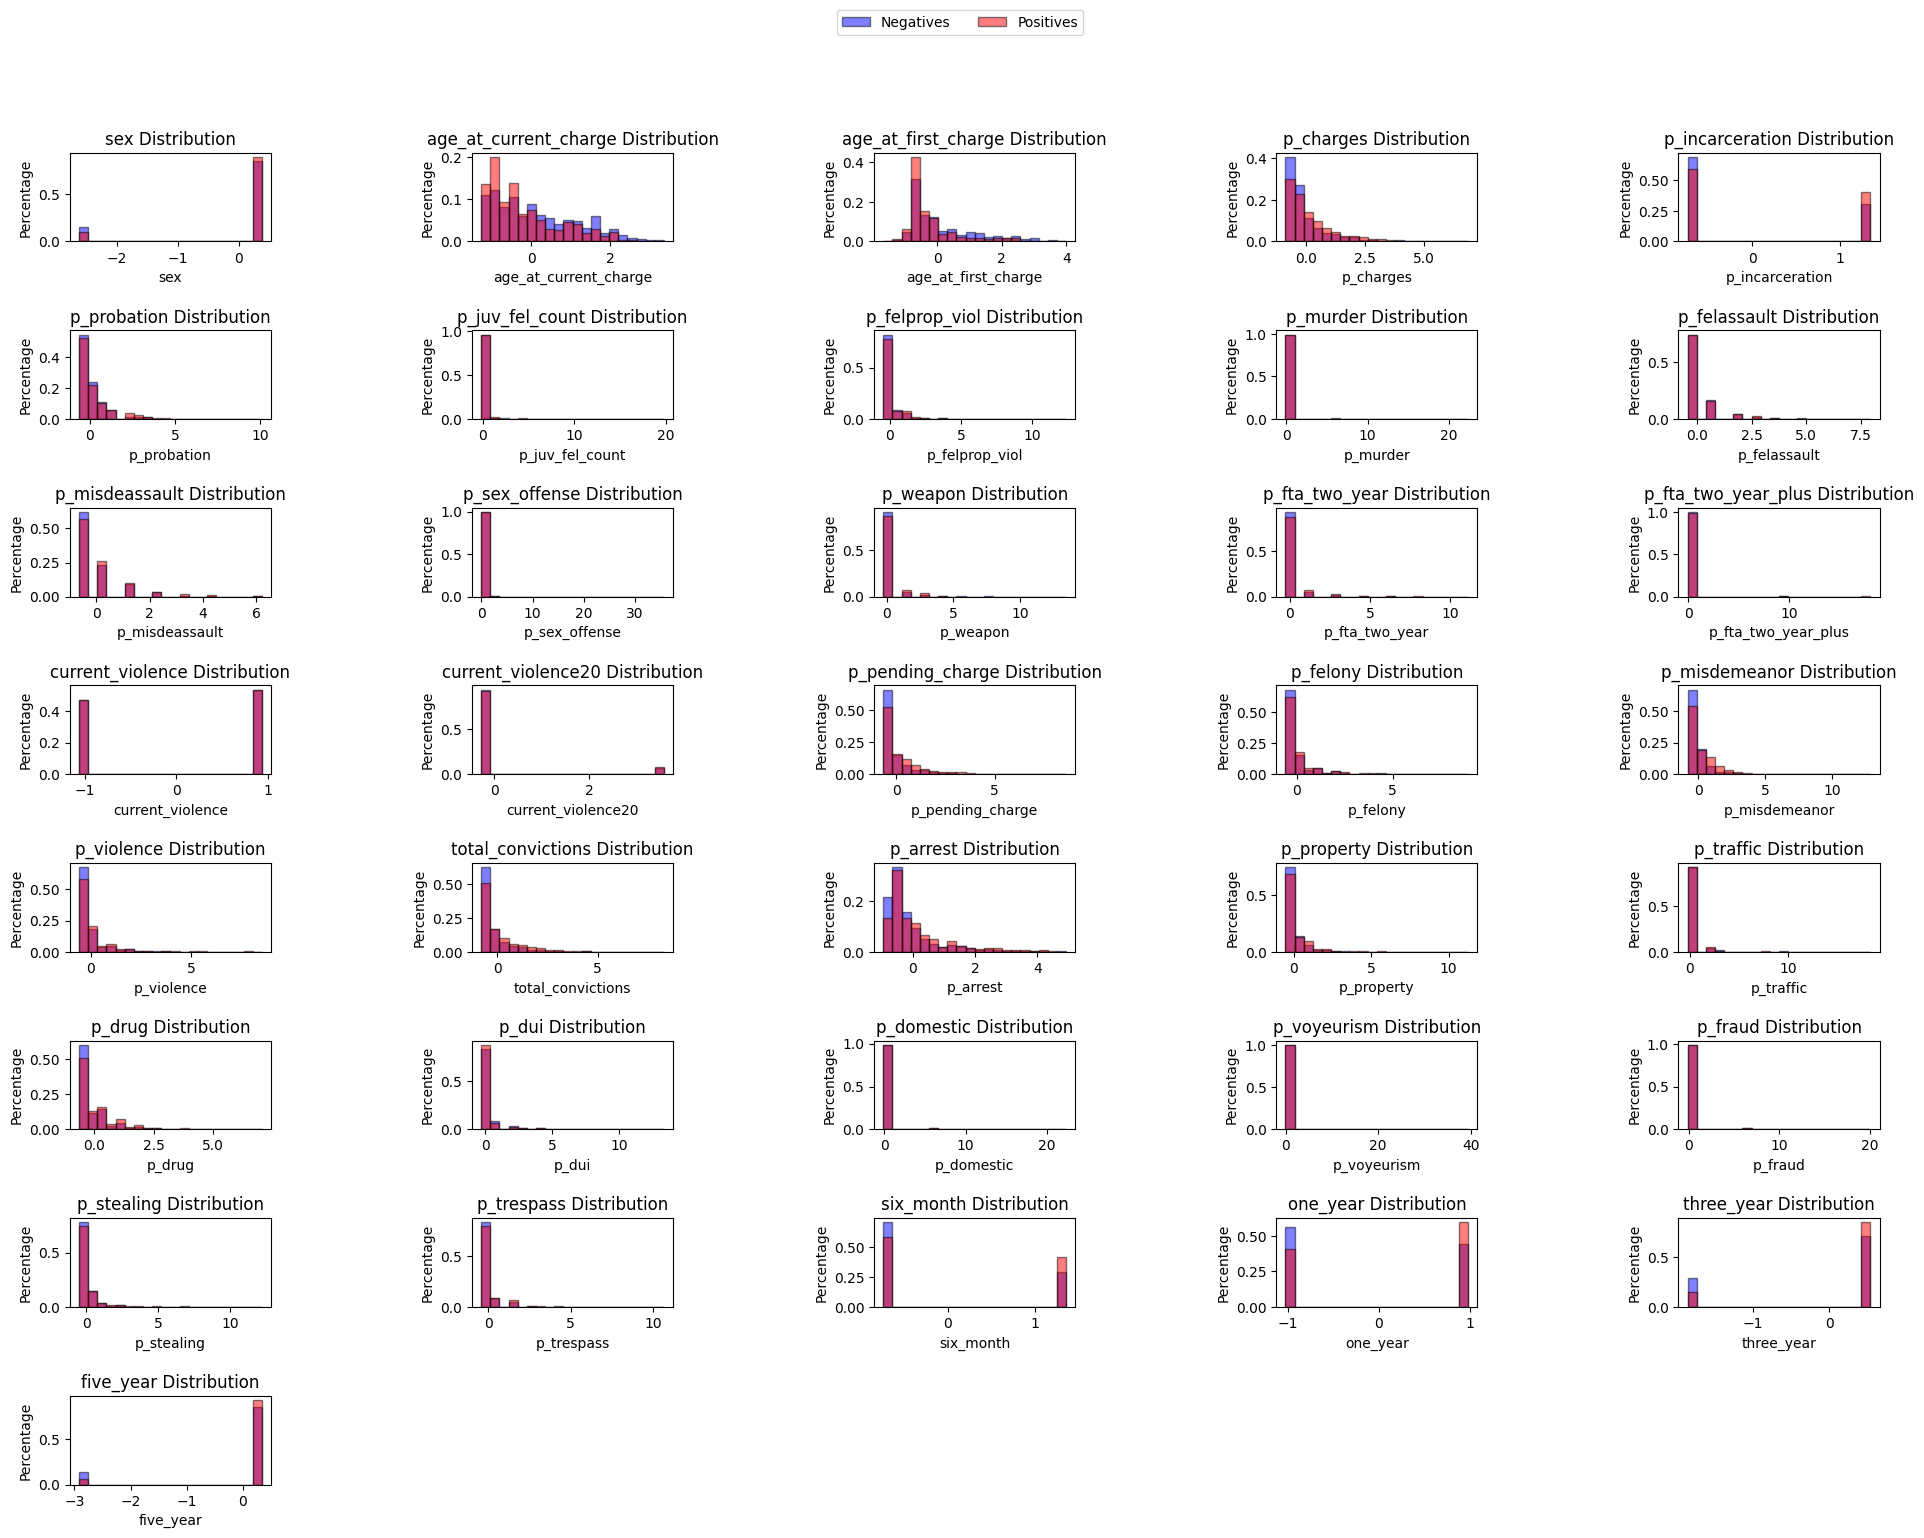

In [37]:

cols = 5
rows = (len(retained_features)+cols-1)//cols 

fig, axes = plt.subplots(rows, cols, figsize=(20,15))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(retained_features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]

    negatives = train_data[train_data['general_two_year'] == 0][feature]
    positives = train_data[train_data['general_two_year'] == 1][feature]

    #bins = np.linspace(min(dataset[feature]), max(dataset[feature]), 21)
    weights_negatives = np.ones_like(negatives) / len(negatives)
    weights_positives = np.ones_like(positives) / len(positives)
    bins = np.linspace(min(train_data[feature]), max(train_data[feature]), 21)
    


    ax.hist(negatives, bins=bins, weights=weights_negatives, color='blue', alpha=0.5, label='Negatives', edgecolor='black')
    ax.hist(positives, bins=bins, weights=weights_positives, color='red', alpha=0.5, label='Positives', edgecolor='black')

    
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(feature)
    ax.set_ylabel("Percentage")
    


for n in range(i+1, rows*cols):
    axes.flatten()[n].axis('off')

plt.subplots_adjust(hspace=1, wspace=1)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))


plt.show()
